In [1]:
'''Clean up trip data files into unified dataset

'''

# %% Initialize
# import glob
import datetime

import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

import numpy.polynomial.polynomial as poly
import scipy.stats as stats

# import geocoder
# import cartopy.crs as ccrs
# from cartopy.io.img_tiles import OSM

path = 'data/'

In [2]:
# Read data
data = pd.read_pickle(f'{path}all_data_cities.pkl')

In [3]:
data['gender'].unique()

array([ 1., nan,  0.])

In [4]:
# Gender - 0=male; 1=female (changed above)
def data_gender(df):
    df = df.copy()
    df.dropna(subset=['gender'], inplace=True)

    gender = df.groupby(by=[data['start_time'].dt.date]).agg({'gender': 'mean'})
    gender.index = pd.to_datetime(gender.index)
    gender_cities = data.groupby(by=[data['start_time'].dt.date, data['start_city'], data['end_city']]).agg({'gender': 'mean'}).reset_index()
    gender_cities.set_index('start_time', inplace=True)
    gender_cities.index = pd.to_datetime(gender_cities.index)

    return gender, gender_cities

# Age
def data_age(df):
    df = df.copy()
    df.dropna(subset=['birth_year'], inplace=True)
    df['age'] = df['start_time'].dt.year - df['birth_year']

    df.drop(df[(df['age'] > 80) | (df['birth_year'] == 1969)].index, inplace=True)

    return df

# User type
def data_user(df):
    df = df.copy()
    df.dropna(subset=['user_type'], inplace=True)

    usertype = df.groupby(by=[df['start_time'].dt.date]).agg({'user_type': 'mean'})
    usertype.index = pd.to_datetime(usertype.index)
    
    usertype_cities = df.groupby(by=[df['start_time'].dt.date, df['start_city'], data['end_city']]).agg({'user_type': 'mean'}).reset_index()
    usertype_cities.set_index('start_time', inplace=True)
    usertype_cities.index = pd.to_datetime(usertype_cities.index)

    return usertype, usertype_cities


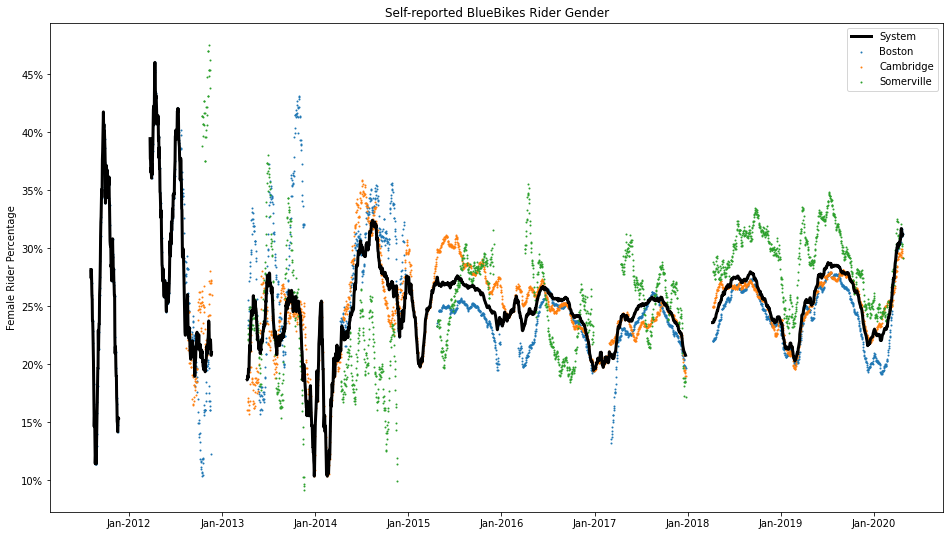

In [5]:
# Plots! - Gender
dataGender, dataGenderCities = data_gender(data)

fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

cityList = ['Boston', 'Cambridge', 'Somerville']

roll_days = 28
min_period = int(roll_days * 0.8)

gender_roll = dataGender.rolling(f'{roll_days}D', min_periods=min_period, center=True).mean()
# ax.scatter(dataGender.index, dataGender['gender'], s=3)
ax.plot(gender_roll, linewidth=3, label='System', color='black')

citiesData = []
labels = []
for city in cityList:
    cityData = dataGenderCities['gender'].loc[(dataGenderCities['start_city'] == city) & (dataGenderCities['end_city'] == city)]
    city_gender_roll = cityData.rolling(f'{roll_days}D', min_periods=min_period, center=True).mean()
    # ax.plot(city_gender_roll, linewidth=1, label=city)
    ax.scatter(city_gender_roll.index, city_gender_roll, s=1, label=city)
    # ax.scatter(cityData.index, cityData, s=1)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_ylabel('Female Rider Percentage')
ax.set_title('Self-reported BlueBikes Rider Gender')
ax.legend()
plt.show()

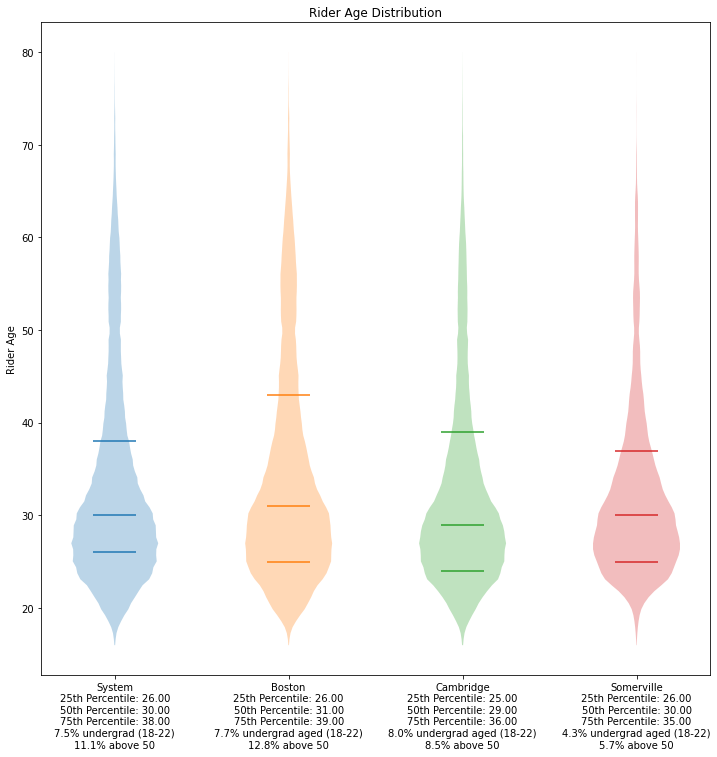

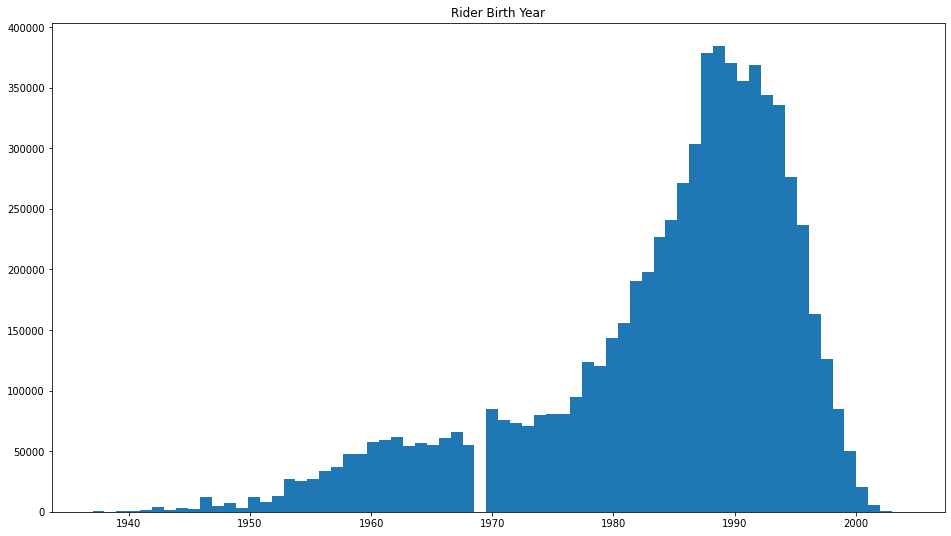

In [6]:
# Plots! - Age
dataAge = data_age(data.copy())

# Violin plot of Rider Age
fig = plt.figure(figsize=(12,12), facecolor='white')
ax = fig.add_subplot(1,1,1)

q50 = dataAge['age'].quantile(0.5)
q75 = dataAge['age'].quantile(0.75)
q25 = dataAge['age'].quantile(0.25)
olderage = 100 - stats.percentileofscore(dataAge['age'], 50)
collegeage = stats.percentileofscore(dataAge['age'], 22) - stats.percentileofscore(dataAge['age'], 18)
label = f'System\n25th Percentile: {q25:0.2f}\n50th Percentile: {q50:0.2f}\n75th Percentile: {q75:0.2f}\n{collegeage:0.1f}% undergrad (18-22)\n{olderage:0.1f}% above 50'
ax.violinplot(dataset=dataAge['age'], positions=[1], quantiles=[.25,.5,.75], showextrema=False)

labels = [label]
cityAges = []

for i, city in enumerate(cityList):
    cityData = dataAge['age'].loc[(dataAge['start_city'] == city) | (dataAge['end_city'] == city)]
    q50 = cityData.quantile(0.5)
    q75 = cityData.quantile(0.75)
    q25 = cityData.quantile(0.25)
    olderage = 100 - stats.percentileofscore(cityData, 50)
    collegeage = stats.percentileofscore(cityData, 22) - stats.percentileofscore(cityData, 18)
    label = f'{city}\n25th Percentile: {q25:0.2f}\n50th Percentile: {q50:0.2f}\n75th Percentile: {q75:0.2f}\n{collegeage:0.1f}% undergrad aged (18-22)\n{olderage:0.1f}% above 50'
    cityAges.append([cityData])
    labels.append(label)

    ax.violinplot(dataset=cityData, positions=[i+2], quantiles=[.2,.5,.8], showextrema=False)

ax.set_xticks(list(range(1,len(cityList)+2)), labels=labels)

ax.set_ylabel('Rider Age')
ax.set_title('Rider Age Distribution')
plt.show()


# Histogram of birth years
fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

bins = int(dataAge['birth_year'].max() - dataAge['birth_year'].min() + 1)

ax.hist(dataAge['birth_year'], bins=bins)
ax.set_title('Rider Birth Year')
plt.show()

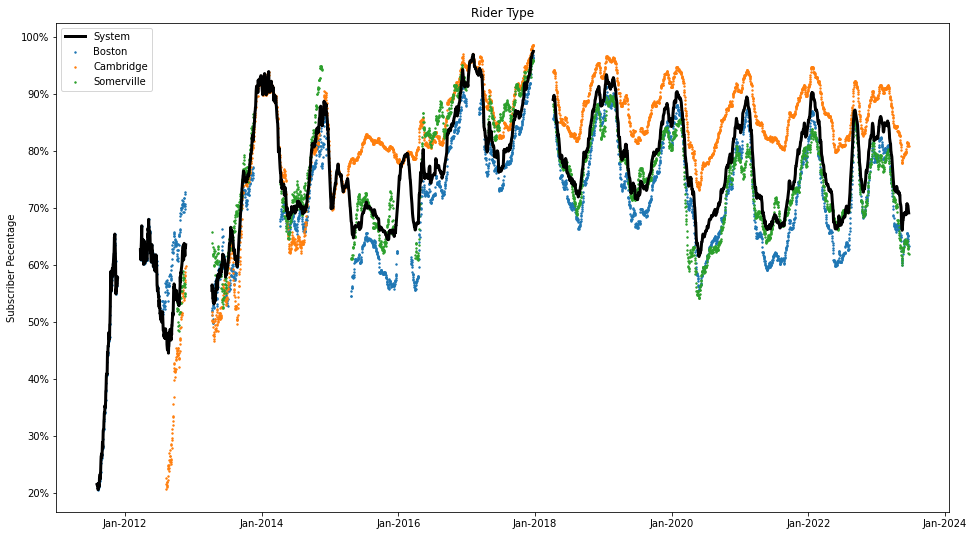

In [7]:
# Plots! - Rider Type
dataUser, dataUserCities = data_user(data)

fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

roll_days = 28
min_period = int(roll_days * 0.8)

usertype_roll = dataUser.rolling(f'{roll_days}D', min_periods=min_period, center=True).mean()
# ax.scatter(dataUser.index, dataUser['user_type'], s=3)
ax.plot(usertype_roll, linewidth=3, label='System', color='black')
# ax.scatter(usertype_roll.index, usertype_roll, s=5, label='System')

citiesData = []
labels = []
for city in cityList:
    cityData = dataUserCities['user_type'].loc[(dataUserCities['start_city'] == city) & (dataUserCities['end_city'] == city)]
    city_usertype_roll = cityData.rolling(f'{roll_days}D', min_periods=min_period, center=True).mean()
    # ax.plot(city_usertype_roll, linewidth=3, label=city)
    ax.scatter(city_usertype_roll.index, city_usertype_roll, s=2, label=city)
    # ax.scatter(cityData.index, cityData, s=1)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_ylabel('Subscriber Pecentage')
ax.set_title('Rider Type')
ax.legend()
plt.show()

c:\Users\Scott\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\linalg\linalg.py:2146: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
c:\Users\Scott\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\axes\_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


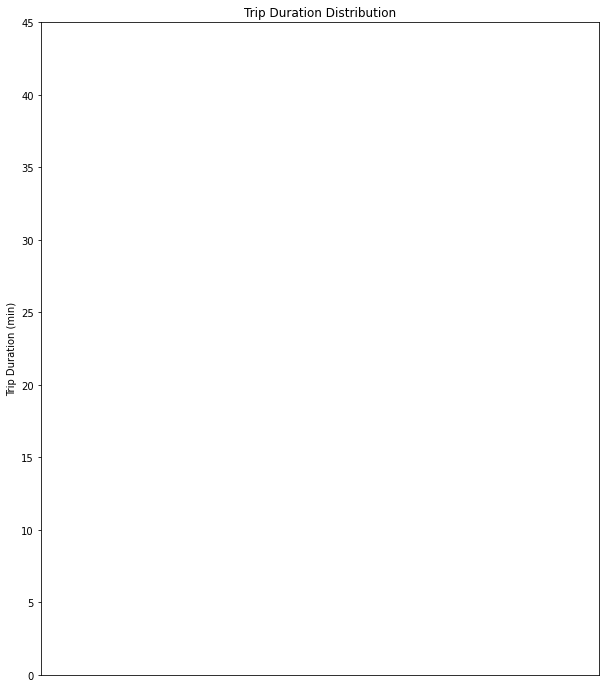

In [8]:
# Plots! - Trip Duration

df = data.drop(data[(data['duration'] > 4*60*60)].index)

q50 = df['duration'].quantile(0.5) / 60
q75 = df['duration'].quantile(0.75) / 60
q25 = df['duration'].quantile(0.25) / 60
label = [f'25th Percentile: {q25:0.1f}\n50th Percentile: {q50:0.1f}\n75th Percentile: {q75:0.1f}']

# Violin plot of Trip Duration
fig = plt.figure(figsize=(10,12), facecolor='white')
ax = fig.add_subplot(1,1,1)

ax.violinplot(dataset=df['duration']/60, quantiles=[.25,.5,.75], showextrema=False, points=1000)

ax.set_xticks([1], labels=label)
ax.set_ylim([0,45])
ax.set_ylabel('Trip Duration (min)')
ax.set_title('Trip Duration Distribution')
plt.show()


# # Histogram of trip duration
# fig = plt.figure(figsize=(16,9))
# ax = fig.add_subplot(1,1,1)

# # bins = df['birth year'].max() - df['birth year'].min() + 1

# ax.hist(df['tripduration'])
# # ax.hist(df['tripduration'], bins=bins)
# ax.set_title('Trip Duration')
# plt.show()

Yearly Peak, pre-Covid | slope=1.60 | intercept=-25385.21 | r_value**2=0.86
Yearly Peak, post-Covid | slope=0.90 | intercept=-12685.18 | r_value**2=0.03
Yearly Low, pre-Covid | slope=0.48 | intercept=-7856.18 | r_value**2=0.98
Yearly Low, post-Covid | slope=0.84 | intercept=-15024.50 | r_value**2=0.98
Yearly Average, pre-Covid | slope=1.02 | intercept=-15994.52 | r_value**2=0.93
Yearly Average, post-Covid | slope=0.42 | intercept=-5547.18 | r_value**2=0.05


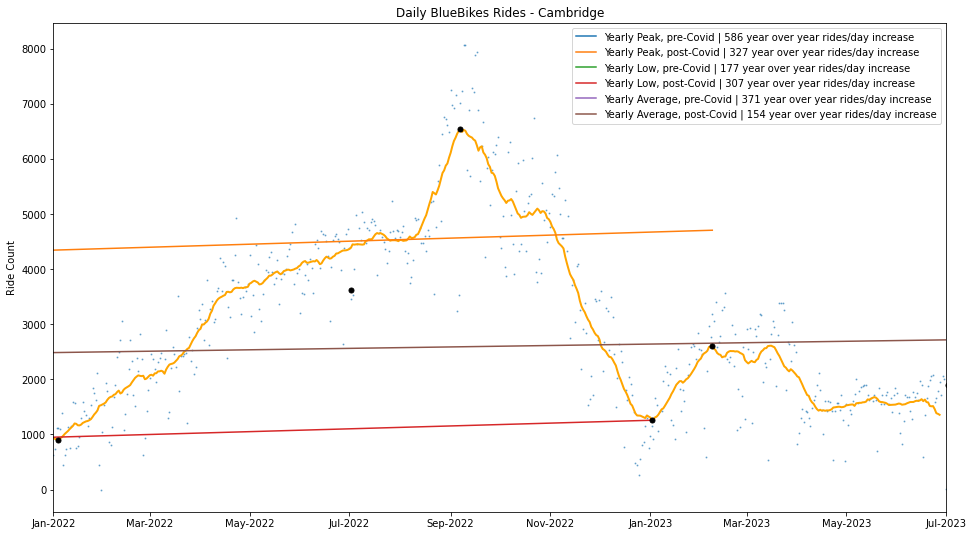

In [8]:
# Plots! - Trip Count

fig = plt.figure(figsize=(16,9), facecolor='white')
ax = fig.add_subplot(1,1,1)

# cityList = ['Boston', 'Cambridge', 'Somerville']

roll_days = 28
min_period = int(roll_days * 0.8)

rideCountsStart = data.groupby([pd.Grouper(key='start_time', freq='1d'), 'start_city']).size()
rideCountsEnd = data.groupby([pd.Grouper(key='end_time', freq='1d'), 'end_city']).size().rename(index=('date','city'))

rideCountsStart.index.rename(['date','city'], inplace=True)
rideCountsEnd.index.rename(['date','city'], inplace=True)

rideCounts = rideCountsStart.add(rideCountsEnd, fill_value=0).divide(2).rename('count').reset_index().set_index('date')

cambCounts = rideCounts['count'][rideCounts['city'] == 'Cambridge']
cambRoll = cambCounts.rolling(f'{roll_days}D', min_periods=min_period, center=True).mean()

ax.scatter(cambCounts.index, cambCounts, s=1, alpha=0.5)
ax.plot(cambRoll, linewidth=2, color='orange')

maxCounts = cambRoll.groupby(cambRoll.index.year).max()
maxDates = cambRoll.groupby(cambRoll.index.year).idxmax()
maxCounts = pd.concat([maxDates, maxCounts], axis=1)
maxCounts.columns = ['count_date', 'count']

minCounts = cambRoll.groupby(cambRoll.index.year).min()
minDates = cambRoll.groupby(cambRoll.index.year).idxmin()
minCounts = pd.concat([minDates, minCounts], axis=1)
minCounts.columns = ['count_date', 'count']

meanCounts = cambRoll.groupby(cambRoll.index.year).mean()
meanDates = (pd.to_datetime(meanCounts.index.values, format='%Y') + pd.Timedelta(value=365/2, unit='days')).to_series().set_axis(meanCounts.index)
meanCounts = pd.concat([meanDates, meanCounts], axis=1)
meanCounts.columns = ['count_date', 'count']
meanCounts['count_date'] = meanCounts['count_date'].dt.strftime('%Y-%m-%d')

ax.scatter(maxCounts['count_date'], maxCounts['count'], marker='o', s=25, c='black', zorder=10)
ax.scatter(minCounts['count_date'], minCounts['count'], marker='o', s=25, c='black', zorder=11)
ax.scatter(meanCounts['count_date'], meanCounts['count'], marker='o', s=25, c='black', zorder=12)

def plot_count_regress(data, title):
    x = mdates.date2num(data['count_date'])
    y = data['count']

    xs = np.linspace(x.min(), x.max(), num=10)
    coefs = poly.polyfit(x, y, 1)
    ffit = poly.polyval(xs, coefs)
    
    slope, intercept, r_value, _, _ = stats.linregress(x, y) # slope, intercept, r_value, p_value, std_err

    print(f'{title} | {slope=:0.2f} | {intercept=:0.2f} | {r_value**2=:0.2f}')

    title = f'{title} | {slope*365.25:0.0f} year over year rides/day increase'

    ax.plot(xs, ffit, label=title)

covid = '2020-03-15'
begin = '2015-01-01'

maxPre = maxCounts[(maxCounts['count_date'] < covid) & (maxCounts['count_date'] > begin)]
maxPost = maxCounts[maxCounts['count_date'] > covid]
plot_count_regress(maxPre, 'Yearly Peak, pre-Covid')
plot_count_regress(maxPost, 'Yearly Peak, post-Covid')

minPre = minCounts[(minCounts['count_date'] < covid) & (minCounts['count_date'] > begin)]
minPost = minCounts[minCounts['count_date'] > covid]
plot_count_regress(minPre, 'Yearly Low, pre-Covid')
plot_count_regress(minPost, 'Yearly Low, post-Covid')

meanPre = meanCounts[(meanCounts['count_date'] < covid) & (meanCounts['count_date'] > begin)]
meanPost = meanCounts[meanCounts['count_date'] > covid]
plot_count_regress(meanPre, 'Yearly Average, pre-Covid')
plot_count_regress(meanPost, 'Yearly Average, post-Covid')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))
ax.set_xlim([datetime.date(2022, 1, 1), datetime.date(2023, 7, 1)])
ax.set_ylabel('Ride Count')
ax.set_title('Daily BlueBikes Rides - Cambridge')
ax.legend()
plt.show()

In [10]:
meanCounts = cambRoll.groupby(cambRoll.index.year).mean()
meanDates = (pd.to_datetime(meanCounts.index.values, format='%Y') + pd.Timedelta(value=365/2, unit='days')).to_series().set_axis(meanCounts.index)
meanCounts = pd.concat([meanDates, meanCounts], axis=1)
meanCounts.columns = ['count_date', 'count']

meanCounts

,count_date,count
date,,
2012,2012-07-01 12:00:00,18.421833
2013,2013-07-02 12:00:00,40.238712
2014,2014-07-02 12:00:00,48.650382
2015,2015-07-02 12:00:00,1002.572077
2016,2016-07-01 12:00:00,1219.005757
2017,2017-07-02 12:00:00,1375.340440
2018,2018-07-02 12:00:00,2128.737008
2019,2019-07-02 12:00:00,2402.919472
2020,2020-07-01 12:00:00,1665.496731
